In [1]:
%matplotlib inline
import math
import random
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
#import pyNN.spiNNaker as p
import pyNN.nest as p    #tested on pynn0.75, nest2.2
import poisson_tools as pstool

#An example of STDP learned weights for a digit from MNIST

##Poissonian Presentation of the digit

Loading MNIST dataset

In [2]:
train_x,train_y = pstool.get_train_data()

Plot a digit

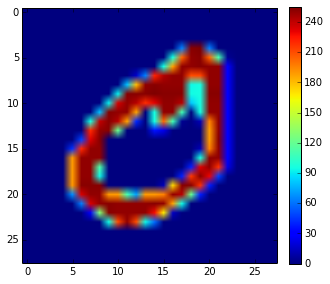

In [3]:
pstool.plot_digit(train_x[21])

###Generating Poisson spike trains

mnist_poisson_gen:
create spike_source_array for pyNN, digit array will be transfered to poissonian trains with a duration time and a silence between the digits.
ruturn python list can be directly use for pyNN.SpikeSourceArray.

In [4]:
random.seed(10)
image_size = 28
max_rate = 2000.
duration = 100000 #ms, 100s
silence = 100 #ms
aer_file = 'test.aedat'
jaer_size = 128
spike_source_data = pstool.mnist_poisson_gen(train_x[21:22], image_size, image_size, max_rate, duration, silence)

spike_to_aerfile and aerfile_to_spike functions convert spike_source_array to and from jAER file.

In [5]:
time_stamp, neuron_id, pol = pstool.spike_to_aerfile(spike_source_data, spike_source_data, aer_file, image_size, jaer_size)
spike_source_array_on, spike_source_array_off = pstool.aerfile_to_spike('test.aedat', 28, 128)   

###setup parameters for pyNN simulation

In [6]:
teach_rate = 50.
cell_params_lif = {'cm': 0.25,
                   'i_offset': 0.0,
                   'tau_m': 20.0,
                   'tau_refrac': 2.0,
                   'tau_syn_E': 1.0,
                   'tau_syn_I': 1.0,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -50.0
                   }
p.setup(timestep=1.0, min_delay=1.0, max_delay=3.0)

0

###SNN Populations: poisson -> input -> output <- teach

In [7]:
pop_poisson = p.Population(image_size*image_size, p.SpikeSourceArray,{'spike_times' : []})
for j in range(image_size*image_size):
    pop_poisson[j].spike_times = spike_source_array_on[j]
pop_input = p.Population(image_size*image_size, p.IF_curr_exp, cell_params_lif)
pop_output = p.Population(1, p.IF_curr_exp, cell_params_lif)
pop_teach = p.Population(1,p.SpikeSourcePoisson,{'rate' : teach_rate,
                                                   'start' : 0,
                                                   'duration' :duration})

###SNN Projections: 
1. poisson->input
2. teach->output\n
3. input--->output: STDP\n

In [8]:
ee_connector = p.OneToOneConnector(weights=3.0)
p.Projection(pop_poisson, pop_input, ee_connector, target='excitatory')
p.Projection(pop_teach, pop_output, ee_connector, target='excitatory')
weight_max = 1.3
stdp_model = p.STDPMechanism(
    timing_dependence=p.SpikePairRule(tau_plus=10.0, tau_minus=10.0),
    weight_dependence=p.MultiplicativeWeightDependence(w_min=0.0, w_max=weight_max, A_plus=0.01, A_minus=0.01)
)
proj_stdp = p.Projection(
        pop_input, pop_output, p.AllToAllConnector(weights = 0.0),
        synapse_dynamics=p.SynapseDynamics(slow=stdp_model)
)

### Run simulation

In [9]:
pop_poisson.record()
p.run(duration+silence)

100101.0

plot trained weights and recorded poission spikes

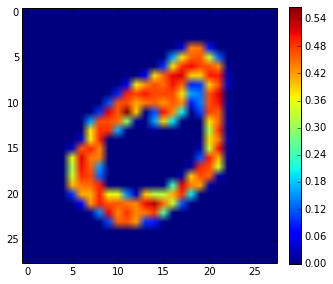

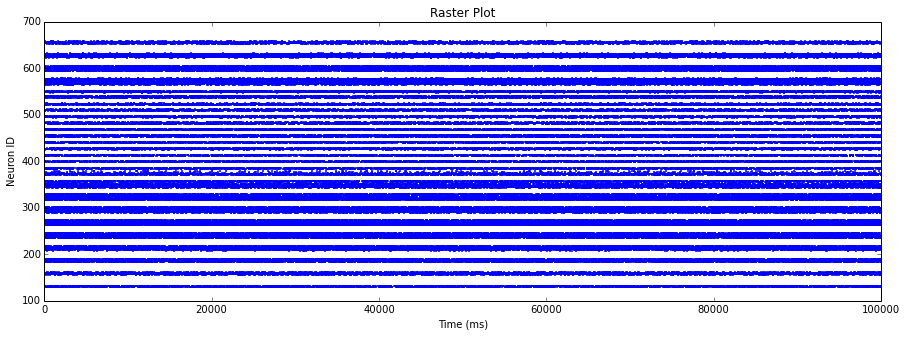

In [13]:
post = proj_stdp.getWeights(format='array',gather=False)
pstool.plot_weight(post)

def plot_spikes(spikes, title):
    if spikes is not None:
        plt.figure(figsize=(15, 5))
        plt.plot([i[1] for i in spikes], [i[0] for i in spikes], ".", markersize=3.0)
        plt.xlabel('Time (ms)')
        plt.ylabel('Neuron ID')
        plt.title(title)

    else:
        print "No spikes received"
spikes = pop_poisson.getSpikes(compatible_output=True)
plot_spikes(spikes,'Raster Plot')
p.end()